In [1]:
#!/usr/bin/env python
import scrapbook as sb
import networkx as nx
import pygraphviz as pygv
import gurobipy as gb
import json
from community import community_louvain
from IPython.display import Image, display

def DrawSol (G, x, filename):
    global n_micros

    DrawG = pygv.AGraph(directed=True, strict='true', splines='true')

    colors = ['green', 'blue', 'red', 'orange', 'yellow', 'purple', 'black', 'gray', 'cyan', 'brown', 'hotpink', 'navy', 'darkgreen', 'chocolate', 'deeppink', 'firebrick', 'gold', 'orchid', 'gold4']
    
    for i in G.nodes():
        if G.nodes[i]['type'] == 'Entity':
            shape='hexagon'
        else:
            shape='circle'

        for k in range(n_micros):
            if x[i,k].x == 1:
                # Get cluster number k
                if k<len(colors):
                    color=colors[k]
                else:
                    color = 'black'
        DrawG.add_node (i, color=color, shape=shape, width=0.1, fontsize=9, label=G.nodes[i]['name'])

    for i in G.edges():
        edge_color = 'black' if G[i[0]][i[1]]['rel_type'] in ['Calls','Persists', 'References'] else 'gray'
        DrawG.add_edge(i[0], i[1], color=edge_color, label=G[i[0]][i[1]]['rel_type'], fontsize='8')
        
    DrawG.layout(prog='dot')
    DrawG.draw(filename)

### _Configuration!_

Keep the project list up-to-date and select the project to be analyzed

### _User input required!_

Update, if needed the default weigth of the edges

In [2]:
project = 'jpetstore' # <-- Set this variable!
# Weighting edges:
w = dict()
w['Calls']=0.8
w['Persists']=1
w['Uses']=0.6
w['References']=0.2
w['Extends']=0

In [3]:
# Parameters
project = "springblog"
w = {"Calls": 0.001, "Persists": 0.001, "References": 0.6551665074711792, "Extends": 0.001, "Uses": 1.0}


In [4]:


with open('projects.json', 'r') as projects:
    project_found = False
    for data in json.load(projects):
        if data['name'] == project:
            analysis_results_basedir = data['analysis_results_basedir']
            project_found = True
    if not project_found:
        print('ERROR: project ' + project + ' does not appear in project.json')

In [5]:
# Set output names

graph_in = analysis_results_basedir + project + '_graph.gml'
communities_out = analysis_results_basedir + project + '_communities.csv'
formulation_out = analysis_results_basedir + project + '_communities_improved_optimization.lp'
solution_csv_out = analysis_results_basedir + project + '_sol_communities_improved_optimization.csv'
graph_image_out = analysis_results_basedir + project + '_sol_communities_improved_optimization.png'
analysis_out = analysis_results_basedir + project + '_sol_communities_improved_optimization.txt'

In [6]:
# Import graph

G = nx.read_graphml(graph_in)

In [7]:
# Add edge weights

for (i, j) in G.edges():
    G[i][j]['w'] = w[G[i][j]['rel_type']]

## Find communities

In [8]:
H = nx.Graph(G) # create an undirected graph H from a directed graph G

# compute the best partition
communities = community_louvain.best_partition(H, weight='w')

# write communities on file
with open(communities_out, 'w') as csv_file:
    csv_file.write('node, cluster/community\n')
    for node in communities:
        csv_file.write(f'{node},{communities[node]}\n')

## Find communities for the entity subgraph

In [9]:
K = nx.Graph(G) # create an undirected graph H from a directed graph G

# Remove non-entity nodes

for i in list(K.nodes):
    if K.nodes[i]['type']!='Entity':
        K.remove_node(i)

# Obtain subgraph of entities that have direct relationships with the persistence layer:
    
        
# compute the best partition
entity_cluster = community_louvain.best_partition(K, weight='w')

# Remove nodes that do not have direct relationships with methods from the cluster dictionary:
e_dict = dict()
# Check if entity has a relationship with some method of the persistence layer (it will remove entities from the controller model, for instance)
for e in entity_cluster:
    e_dict[e] = False
    for (i,j) in G.edges():
        if e==j and G[i][j]['rel_type'] in ['Persists']:
            e_dict[e]=True

# Remove non-related entities
for entity_to_remove in e_dict:
    if not e_dict[entity_to_remove]:
        # print('INFO: Entity ' + G.nodes[entity_to_remove]['name'] + ' removed from the clusters')
        entity_cluster.pop(entity_to_remove)

for i in set(entity_cluster.values()):
    print(f'Community {i}:')
    for entity, cluster in entity_cluster.items():
        if cluster == i:
            print(f' - {G.nodes()[entity]["name"]} (id:{entity})')

Community 4:
 - Setting (id:4)
Community 5:
 - User (id:5)
 - Post (id:7)
 - Tag (id:8)


### _User input required!_

Refine, if needed, entity clusters

In [10]:
# Remove entity from its cluster
entity_ids_to_remove = [] # <-- Put Ids as strings (example: ['1', '3']

# Place entity into a cluster
entities_clusters_to_place = [] # <-- Example: entity X in cluster Y: ('X', 5)


for e in entity_ids_to_remove:
    entity_cluster.pop(e)
    print(f'INFO: Removed entity {G.nodes()[e]["name"]} from clusters')

for (e, cluster) in entities_clusters_to_place:
    entity_cluster[e] = cluster
    print(f'INFO: Entity {G.nodes()[e]["name"]} put into cluster {cluster}')

In [11]:
# Some cluster may have disappeared: remaining clusters need to be renumbered
cluster_map = dict()
counter=0
number_mapping = dict() # maps the old cluster number with the new one
for entity_key, old_number in entity_cluster.items():
    if old_number not in number_mapping:
        number_mapping[old_number] = counter
        counter+=1
    cluster_map[number_mapping[old_number]] = cluster_map.get(number_mapping[old_number], []) + [entity_key]
    
for cluster in cluster_map:
    print('Entities in community ' + str(cluster) + ': ' + str([G.nodes[entity_key]['name'] for entity_key in cluster_map[cluster]]))

n_micros = len(cluster_map)

Entities in community 0: ['Setting']
Entities in community 1: ['User', 'Post', 'Tag']


In [12]:
# Resolve conflicts of distribution of entities into communities: if entities of the same community are in different clusters, then remove the community from the dictionary

communities_dict = dict() # Map community -> entities into the communities


for node in G.nodes():
    if G.nodes[node]['type'] == 'Entity':
        communities_dict[communities[node]] = communities_dict.get(communities[node], []) + [node]

communities_to_relax = []

for community in communities_dict:
    clusters = []
    for cluster, entities in cluster_map.items():
        for e in entities:
            if e in communities_dict[community]:
                clusters.append(cluster)
    print(f'Entities in community {community} are in clusters: {clusters}')
    if len(clusters) > 0 and not all(clusters[0] == c for c in clusters):
        #print(f'Remove community {community}')
        communities_to_relax.append(community)

nodes_to_remove_from_dict = []
for node in communities.keys():
    if communities[node] in communities_to_relax:
        nodes_to_remove_from_dict.append(node)

for node in nodes_to_remove_from_dict:
    del communities[node]

print(f'Relaxed communities: {communities_to_relax}')

Entities in community 0 are in clusters: [1]
Entities in community 1 are in clusters: []
Entities in community 2 are in clusters: []
Entities in community 3 are in clusters: []
Entities in community 4 are in clusters: [0]
Entities in community 6 are in clusters: [1]
Entities in community 7 are in clusters: [1]
Relaxed communities: []


## ILP Formulation

In [13]:
model = gb.Model()

# Variables
x = model.addVars(((i,k) for i in G.nodes() for k in range(n_micros)),\
                  vtype=gb.GRB.BINARY, name='x')

z = model.addVars(((i,j,k) for (i,j) in G.edges() for k in range(n_micros)), vtype=gb.GRB.BINARY, name='z')

y = model.addVars(((i,j) for (i,j) in G.edges()), vtype=gb.GRB.BINARY, name='y')

# Each node has to be in one and only one microservice
model.addConstrs((x.sum(i, '*') == 1 for i in G.nodes()), name='(1)microservice-belonging')

# A microservice can not be composed of entities only
model.addConstrs((gb.quicksum(x[i,k] for i in G.nodes() if G.nodes[i]['type']!='Entity') >= 1 for k in range(n_micros)), name='(2)microservice-composition')

# Bonding variables
model.addConstrs((z[i,j,k]-x[i,k] <= 0 for (i,j) in G.edges() for k in range(n_micros)), name='(3)bonding-z-to-x')
model.addConstrs((z[i,j,k]-x[j,k] <= 0 for (i,j) in G.edges() for k in range(n_micros)), name='(4)bonding-z-to-x')
model.addConstrs((x[i,k]+x[j,k]-z[i,j,k] <= 1 for (i,j) in G.edges() for k in range(n_micros)), name='(5)bonding-z-to-x')

model.addConstrs((y[i,j]==gb.quicksum(z[i,j,k] for k in range(n_micros)) for (i,j) in G.edges()), name='(6)bonding-y-to-z')


########## Added constraints ##########

# Force each entity from the kth cluster to be in the kth microservice
model.addConstrs((x[i,k]==1 for k in cluster_map for i in cluster_map[k]), name='(7)bonding-x-to-entity-clusters')

# Force node of the same community to be in the same (consider a community only if there are not entities from different clusters)
communities_constraint = model.addConstrs((y[i,j]==1 for (i,j) in G.edges() if i in communities and j in communities and communities[i]==communities[j]), name='(8)bonding-y-to-communities')


########## Objective function ##########

coupling = gb.quicksum(G.edges[i,j]['w']*(1-y[i,j]) for (i,j) in G.edges())

model.setObjective(coupling, gb.GRB.MINIMIZE)

model.write(formulation_out)

Set parameter WLSAccessID


Set parameter WLSSecret


Set parameter LicenseID to value 2713550


Academic license 2713550 - for non-commercial use only - registered to av___@gmail.com


In [14]:
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Linux Mint 22.1")


CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


Academic license 2713550 - for non-commercial use only - registered to av___@gmail.com


Optimize a model with 1269 rows, 629 columns and 3021 nonzeros


Model fingerprint: 0x2114e170


Variable types: 0 continuous, 629 integer (629 binary)


Coefficient statistics:


  Matrix range     [1e+00, 2e+00]


  Objective range  [1e-03, 1e+00]


  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+00]


Presolve removed 1269 rows and 629 columns


Presolve time: 0.00s


Presolve: All rows and columns removed


Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)


Thread count was 1 (of 8 available processors)


Solution count 1: 0.003 


Optimal solution found (tolerance 1.00e-04)


Best objective 2.999999999965e-03, best bound 2.999999999965e-03, gap 0.0000%


## Result Analysis

In [15]:
# Compute cohesion:
inside_w = dict()
outside_w = dict()
total_w = 0

for i,j in G.edges():
    total_w += G[i][j]['w']
    for k in range(n_micros):
        if z[i,j,k].x == 1: # Edge (i,j) is inside microservice k: sum the weight as inside
            inside_w[k] = inside_w.get(k, 0) + G[i][j]['w']
        if x[i,k].x == 1: # Edge (i,j) has its origin in k: sum the weigth as outside
            outside_w[k] = outside_w.get(k, 0) + G[i][j]['w']

cohesion_dict = dict()
for k in range(n_micros):
    cohesion_dict[k] = inside_w[k] / outside_w[k]

cohesion = sum(cohesion_dict.values())/n_micros

In [16]:
show_methods = False

analysis_output = ""

analysis_output += f'Found {str(n_micros)} microservices\n'

analysis_output += f'Total coupling value: {model.objVal} ({model.objVal/n_micros} avg.)\n'
analysis_output += f'Cohesion value: {cohesion}\n\n'

for k in range(n_micros):
    analysis_output += f'Entities in Microservice {str(k)}:\n'
    for i in G.nodes():
        if G.nodes[i]['type'] == 'Entity' and x[i,k].x == 1:
            analysis_output += f'- {G.nodes[i]["name"]}\n'

if show_methods:
    for k in range(n_micros):
        analysis_output += f'\n\nMethods in Microservice {str(k)}:\n'
        for i in G.nodes():
            if G.nodes[i]['type'] == 'Method' and x[i,k].x == 1:
                analysis_output += f'- {G.nodes[i]["name"]} ({G.nodes[i]["class_name"]})\n'

mcalls = 0
references = 0
uses = 0
persists = 0

for i,j in G.edges():
    if y[i,j].x == 0:
        if G[i][j]['rel_type'] == 'Calls':
            mcalls += 1 
        elif G[i][j]['rel_type'] == 'References':
            references += 1
        elif G[i][j]['rel_type'] == 'Uses':
            uses += 1
        elif G[i][j]['rel_type'] == 'Persists':
            persists += 1

analysis_output += f'\n\n\n# of method calls crossing microservices: {mcalls}'
analysis_output += f'\n# of entity references crossing microservices: {references}'
analysis_output += f'\n# of entity usages crossing microservices: {uses}'
analysis_output += f'\n# of methods persisting entities of other microservices: {persists}'

print(analysis_output)

sb.glue("n_micros", n_micros)
sb.glue("avg_cop", model.objVal/n_micros)
sb.glue("cohesion", cohesion)
sb.glue("n_calls", mcalls)
sb.glue("n_refs", references)
sb.glue("n_uses", uses)
sb.glue("n_persist", persists)
sb.glue("total_w", total_w)

with open(analysis_out, 'w') as analysis_file:
    analysis_file.write(analysis_output)

Found 2 microservices
Total coupling value: 0.0029999999999645866 (0.0014999999999822933 avg.)
Cohesion value: 0.9999685591712193

Entities in Microservice 0:
- SettingsForm
- Setting
- BaseModel
Entities in Microservice 1:
- UserForm
- PostForm
- Message
- User
- Post
- Tag



# of method calls crossing microservices: 0
# of entity references crossing microservices: 0
# of entity usages crossing microservices: 0
# of methods persisting entities of other microservices: 0


In [17]:
with open(solution_csv_out, 'w') as results_csv:
    results_csv.write('node_key,microservice\n')
    counter = 0
    for i in G.nodes():
        for k in range(n_micros):
            if x[i,k].x == 1:
                results_csv.write(f'{i},{k}\n')
                counter+=1
    
    if counter!=len(G.nodes()):
        print('Error! There are nodes not assigned into microservices?!')

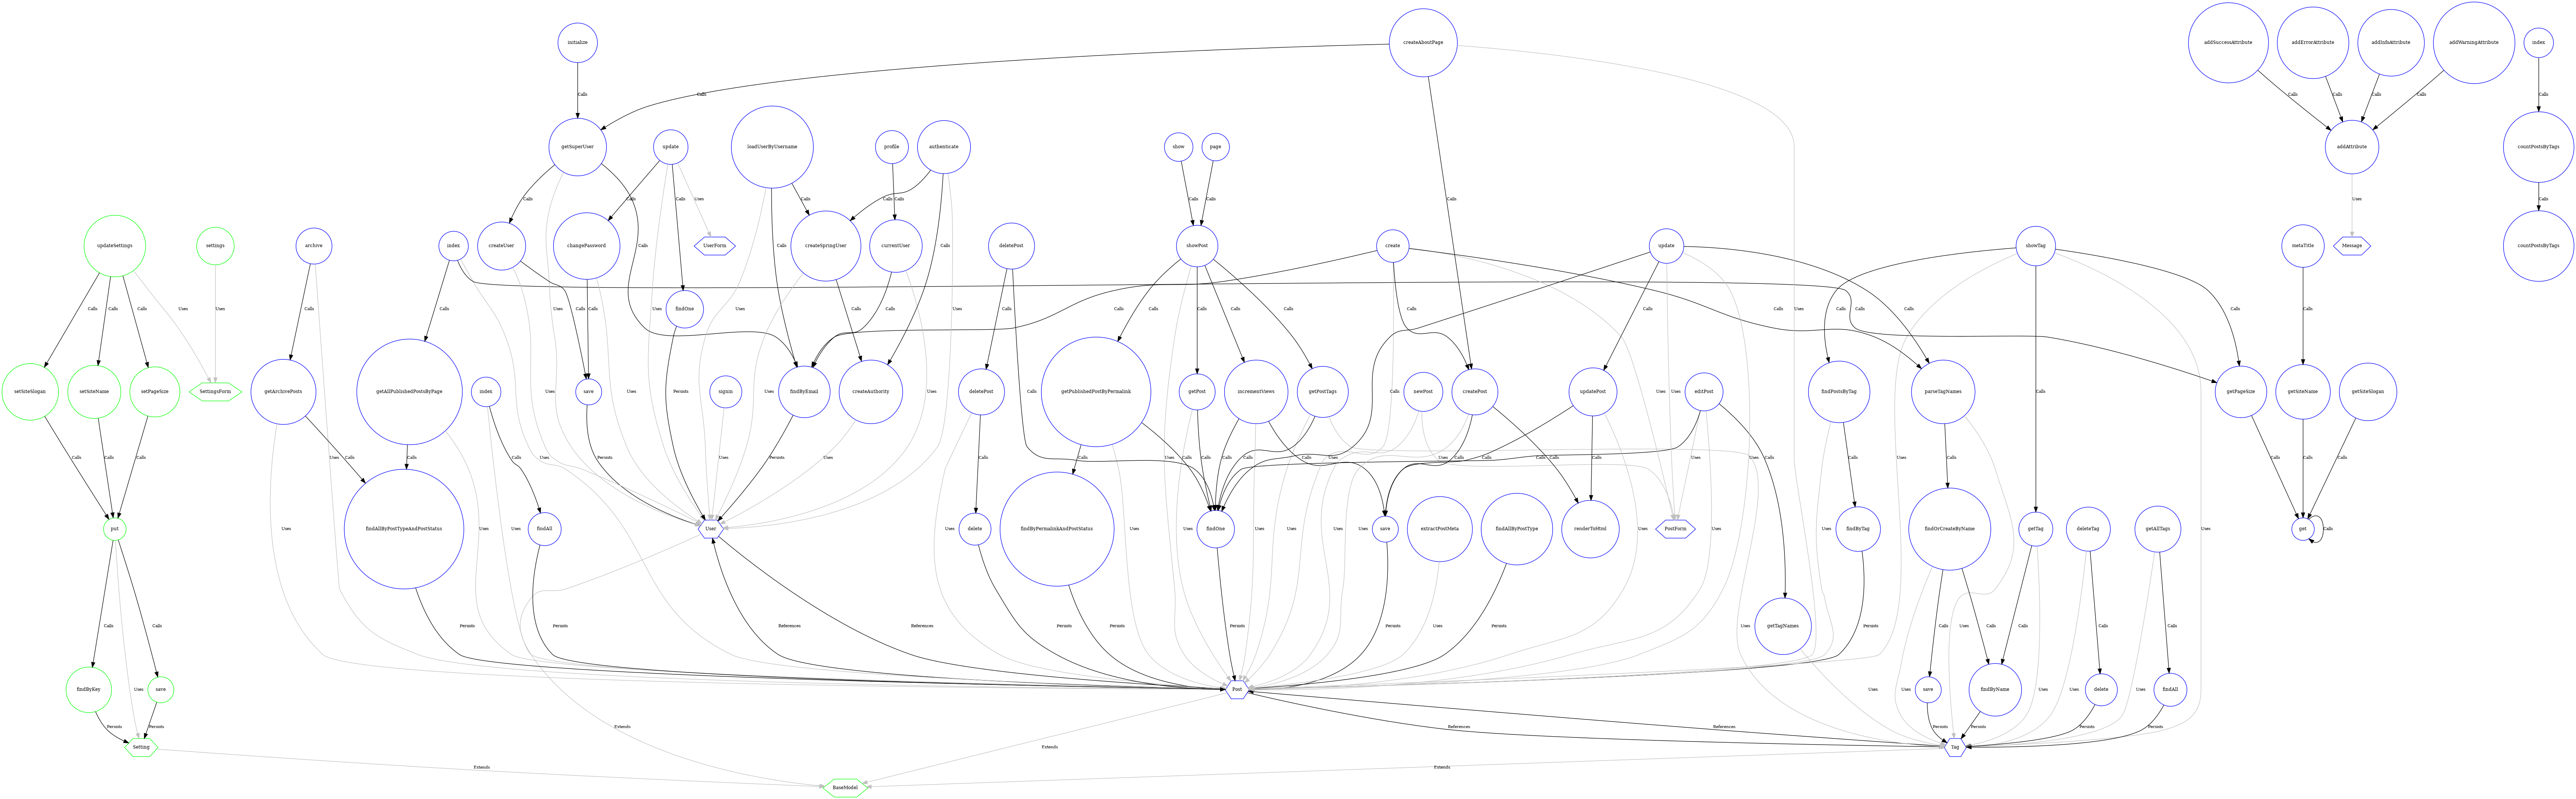

In [18]:
DrawSol(G, x, graph_image_out)

display(Image(filename = graph_image_out))